<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Doc2Vec/Doc2Vec_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Um dos grandes desafios de algoritmos de ciência da computação é a representação numérica de textos e documentos. Neste sentido, apresentamos uma breve explicação de um modelo que é visto como uma extensão do Word2Vec, previamente descrito, denominado **Doc2Vec** ou **Paragraph Vector** - Vetor de Parágrafos.

Tal modelo foi roposto por Tomas Mikolov e Quoc Le [[1]](https://arxiv.org/pdf/1405.4053.pdf), ambos funcionários do Google na época do desenvolvimento do mesmo, em 2014.

Para a apresentação da parte teórica, utilizamos como base as referências dadas em [[2]](https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da), [[3]](https://aclanthology.org/W16-1609.pdf), [[4]](https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137) e [[5]](http://dspace.unipampa.edu.br/bitstream/riu/1601/1/An%C3%A1lise%20de%20sentimento%20usando%20a%20representa%C3%A7%C3%A3o%20distribu%C3%ADda%20de%20par%C3%A1grafos%20para%20o%20portugu%C3%AAs.pdf).

##O que é o Doc2Vec e como funciona

Como dito acima, o Doc2Vec, também chamado de $\textit{Paragraph Vector}$ (Vetor de Paragráfos), pode ser visto como uma extensão do Word2Vec no sentido de, no caso do Word2Vec, cujo objetivo é a representação de palavras no espaço real d-dimensional ($R^d$, $\,$ $d \in \textbf{Z}^{+}$), ser utilizado para a representação de documentos no espaço d-dimensional.

O Vetor de Paragráfos é um algoritmo não supervisionado que aprende representações vetoriais diferentes para as palavras de variados textos. Apesar do seu nome, ele enfatiza o fato que podemos utilizá-lo para textos de diversos tamanhos, desde simples sentenças até enormes documentos.

Agora veremos brevemente a estrutura do Vetor de Parágrafos.

## Alguns detalhes da estrutura do Doc2Vec

O Doc2Vec possui duas variações: PV-DM e DBOW, possuindo algumas semelhanças com o Word2Vec. Explicaremos brevemente como essas variações funcionam abaixo. 

### PV-DM: Paragraph Vector - Distributed Memory

Essa abordagem se assemelha ao CBOW (Continuous Bag-Of-Words) do Word2Vec, uma vez que recebe como entrada as palavras de contexto (uma vizinhança da palavra $\textit{target}$) e retorna um vetor de probabilidades da palavra pertencer àquele contexto. Porém uma diferença se torna presente: a presença de uma matriz de paragráfos (representada por D na figura abaixo), realizando o mapeamento dos paragráfos para vetores distintos de palavras.

Assim, cada parágrafo é mapeado para um único vetor, que representa uma coluna em **D** e cada palavra também é mapeada para um único vetor, que representa cada coluna em **W**. Depois disso, é feita a média ou concatenação desses vetores para a predição da próxima palavra no contexto.



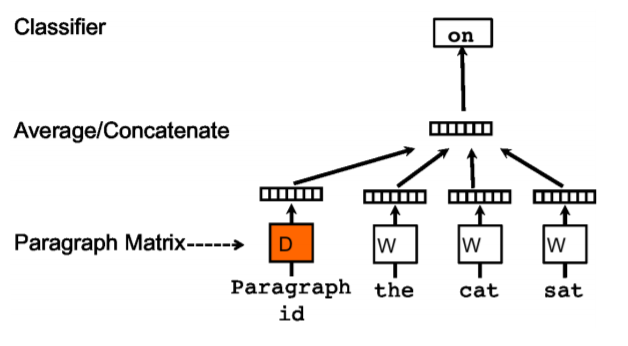

Fonte: Distributed Representations of Sentences and Documents [[1]](https://arxiv.org/pdf/1405.4053.pdf)


O token de parágrafos funciona memorizando o que está faltando do contexto e por isso o nome Distributed Memory.  

Após o treinamento, o Vetor de Parágrafos pode ser utilizado como *features* em modelos convencionais, como a Regressão Logística, CatBoost, Florestas Aleatórias, XGBoost, etc. 

Algumas vatangens dos Vetores de Parágrafos são o fato deles utilizarem dados não rotulados e fornecerem uma boa generalização para altas dimensões, preservando a semântica e a ordem das palavras. 


### PV-DBOW: Paragraph Vector - Distributed Bag-Of-Words

Essa abordagem, por sua vez, é semelhante ao Skip-Gram do Word2Vec, ou seja, no caso desse modelo, dado uma palavra, o objetivo é prever o contexto. No DBOW, é utilizado o Vetor de Paragráfos para prever as palavras de um determinado texto ou uma amostra desse texto.

E também pode ser visto como o modelo acima, sendo que os vetores de palavras **W** são ignorados durante o processo de treinamento e o modleo é forçado a prever palavras escolhidas aleatoriamente do parágrafo.



A imagem abaixo representa um esquema simplificado de como PV-DBOW atua.

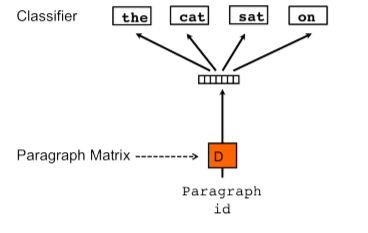

Fonte: Distributed Representations of Sentences and Documents [[1]](https://arxiv.org/pdf/1405.4053.pdf)


Como vantagem, essa abordagem requere menos armazenamento, sendo assim mais eficiente, uma vez que os vetores de palavras são ignorados.

#Mão na massa

Agora vamos ver uma aplicação do Doc2Vec em uma tarefa de classificação com um conjunto de dados de textos jurídicos com seus status: Ativo, Suspenso ou Arquivado. Comecemos com a parte brevemente descritiva e de pré-processamento dos dados. 

##Importando

Vamos importar as bibliotecas necessárias para a utilização do modelo.

In [ ]:
from google.colab import drive
from IPython.display import clear_output

import re
!pip install ftfy
import ftfy

!pip install gensim==3.8.1
from gensim.models.doc2vec import Doc2Vec

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/legalnlp21/legalnlp
from legalnlp.clean_functions import *
clear_output()

Célula de comando para fazer o download do modelo Doc2Vec pré-treinado.

In [ ]:
from legalnlp.get_premodel import *
get_premodel('wodc')

Aqui vamos importar o conjunto de dados no qual iremos trabalhar neste tutorial:

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

E uma breve visualização desses dados:

In [ ]:
data.head()

text        label
0  Início da Execução Juntado 0008003-11.2018.8.2...   H:Suspenso
1  Ofício Requisitório - Comunicação - Protocolo ...  H:Arquivado
2  Arquivado Provisoriamente aguardando manifestação   H:Suspenso
3  Petição Juntada Juntada a petição diversa - Ti...      H:Ativo
4  Remetidos os Autos para o Arquivo Geral – Devo...  H:Arquivado

Esse conjunto de dados possui 6449 observações e 2 variáveis.

Vamos ver agora se temos dados faltantes:

In [ ]:
print("Quantidade de dados faltantes: ", data.isna().any().sum())

Quantidade de dados faltantes:  0


Isso é bom.Não temos nenhum dado faltante! Porém, vemos que os dados precisam ser limpos antes de serem aplicados no modelo, então vamos aplicar um função que limpa essas observações da coluna $text$.

Aplicamos então a função de limpeza na coluna $text$:

In [ ]:
data['text'] = data['text'].apply(lambda x: clean(x))

E obtemos os dados agora limpos, vamos dar uma olhada:

In [ ]:
str(data.loc[1,'text'])

'ofício requisitório - - comunicação - - protocolo eletrônico - - depre'

## Carregando o Modelo

Agora vamos carregar o modelo Doc2Vec pré-treinado, com abordagem PV-DBOW, de tamanho: $size = 100$ e tamanho de janela: $window\_size = 15$.

In [ ]:
model = Doc2Vec.load('/content/W2V_D2V/w2v_d2v_dbow_size_100_window_15_epochs_20')

Com o modelo carregado, podemos utilizar alguns métodos fornecidos na documentação da biblioteca Gensim [[2]](https://radimrehurek.com/gensim/models/doc2vec.html) para o Doc2Vec.

Com o modelo pré-treinado, podemos inferir novos vetores para novas senteças. 

In [ ]:
model.infer_vector("Textos Jurídicos")

array([-0.10737669, -0.17893365, -0.03465467, -0.25847635,  0.17092067,
        0.1534895 , -0.30930158, -0.01065105,  0.17944641, -0.11310524,
        0.02485312, -0.08060912, -0.01928307, -0.06375106,  0.31571838,
       -0.09828064, -0.21189685,  0.10901646,  0.0297659 , -0.46468136,
       -0.42926717, -0.04128577, -0.20833872, -0.13600574,  0.06040049,
       -0.10537662, -0.3091857 ,  0.04038155,  0.13540229,  0.56745607,
        0.07308754, -0.08955409, -0.14211723, -0.39067736, -0.32699746,
       -0.03341701,  0.05267402, -0.3725988 ,  0.04251944,  0.05440333,
       -0.11179563, -0.25143197, -0.29449764, -0.44987047, -0.0484409 ,
       -0.0645289 , -0.42116943, -0.22514701, -0.4549325 , -0.19763605,
       -0.33350435, -0.13820575,  0.22015211,  0.02133388, -0.18418501,
       -0.18270221, -0.05374643,  0.21826887, -0.13548534, -0.48067006,
       -0.1619591 ,  0.06573128,  0.2415433 ,  0.13271895,  0.01596936,
       -0.18046954,  0.31670016, -0.07192493, -0.16081236, -0.10

In [ ]:
model.wv.similar_by_word("banco")

[('brasil', 0.7986418008804321),
 ('banco_itaú', 0.6769572496414185),
 ('banco_mercantil', 0.6748969554901123),
 ('bradesco', 0.665328860282898),
 ('banrisul', 0.6483218669891357),
 ('banco_santander', 0.6408952474594116),
 ('santander', 0.6307247877120972),
 ('agência', 0.6243692636489868),
 ('bnb', 0.6186673641204834),
 ('caixa_econômica_federal', 0.604042112827301)]

##De textos para vetores

Primeiramente vamos transformar as $labels$ aplicando o LabelEncoder da biblioteca sklearn.

In [ ]:
encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(encoder.fit_transform(data['label']))
data.loc[[0, 1, 5]]

text        label  encoded
0  início da execução juntado [processo] - - cump...   H:Suspenso        2
1  ofício requisitório - - comunicação - - protoc...  H:Arquivado        0
5  petição juntada nº protocolo : wscb [numero] t...  H:Arquivado        0

Agora vamos inferir os textos para obter vetores.

In [ ]:
from tqdm import tqdm

In [ ]:
def vetor_inferido(texto):

  string = str(texto).split()

  inferido = model.infer_vector(string, steps = 20)
  
  vetores = np.array(inferido)

  return vetores

In [ ]:
data['infered'] = data['text'].apply(lambda x: vetor_inferido(x))

In [ ]:
data.head(5)

text  ...                                            infered
0  início da execução juntado [processo] - - cump...  ...  [0.15755469, -0.053780857, -0.07847173, -0.036...
1  ofício requisitório - - comunicação - - protoc...  ...  [-0.01456402, -0.009129824, -0.2275198, 0.0795...
2  arquivado provisoriamente aguardando manifestação  ...  [-0.18893974, -0.14138663, -0.0727899, -0.1467...
3  petição juntada juntada a petição diversa - - ...  ...  [0.114631094, -0.060723316, -0.40722123, 0.309...
4  remetidos os autos para o arquivo geral – devo...  ...  [-0.008518125, -0.18757719, 0.028055932, -0.10...

[5 rows x 4 columns]

In [ ]:
for i in range(0, 100):
  data[str(i)] = np.vstack(data.loc[:, 'infered'])[:, i]

In [ ]:
data.head(5)

text  ...        99
0  início da execução juntado [processo] - - cump...  ... -0.199236
1  ofício requisitório - - comunicação - - protoc...  ... -0.420514
2  arquivado provisoriamente aguardando manifestação  ... -0.256589
3  petição juntada juntada a petição diversa - - ...  ... -0.758551
4  remetidos os autos para o arquivo geral – devo...  ... -0.562865

[5 rows x 104 columns]

### Dados de Treino e Teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( data.drop(columns = ['encoded', 'text', 'label', 'infered']), data['encoded'], random_state = 42, test_size = 0.3)

In [ ]:
# Tamanhos dos x e y de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4514, 100)
(1935, 100)
(4514,)
(1935,)


##Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Instanciando o modelo de Regressão Logística em que será feito o cross-validaton em seguida
log_reg = LogisticRegression(max_iter = 1000,
                             random_state = 42, 
                             solver = 'liblinear')

log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Definindo o espaço de busca de parâmetros
space = dict()
space['solver'] = ['liblinear']#, 'lbfgs']
space['penalty'] = ['l1']
space['C'] = np.logspace(-3, 3, 100)

rscv = RandomizedSearchCV(log_reg, space, cv = 3, n_jobs = -1, verbose = 1, random_state = 42, n_iter = 30)

# Fazendo o cross-validation
result = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.0s finished


In [ ]:
# Melhores hiperparâmetros
print('Melhor acurácia: %s' % result.best_score_)
print('Melhores Hiperparâmetros: %s' % result.best_params_)

Melhor acurácia: 0.8360680120638063
Melhores Hiperparâmetros: {'solver': 'liblinear', 'penalty': 'l1', 'C': 15.199110829529332}


In [ ]:
log_reg = LogisticRegression(penalty = result.best_params_['penalty'],
                             C = result.best_params_['C'],
                             solver = result.best_params_['solver'],
                             max_iter = 10000,
                             random_state = 42)

# Treinando os modelos com os melhores hiperparâmetros
log_reg.fit(X_train, y_train)

LogisticRegression(C=15.199110829529332, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=42, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# y hat - predicted values for y
y_pred = log_reg.predict(X_test)
y_pred[:5]

array([1, 0, 1, 0, 1])

In [ ]:
print("A acurácia do modelo é: ", accuracy_score(y_test, y_pred))

A acurácia do modelo é:  0.8377260981912145


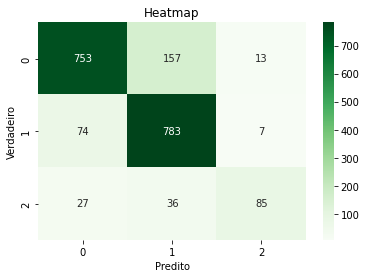

In [ ]:
# Plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       923
           1       0.80      0.91      0.85       864
           2       0.81      0.57      0.67       148

    accuracy                           0.84      1935
   macro avg       0.83      0.77      0.79      1935
weighted avg       0.84      0.84      0.84      1935



##CatBoost - Categorical Boost

Aqui vamos aplicar um modelo chamado CatBoost (Categorical Boosting), que é um modelo de aprendizado por comitê (ensemble learning).

In [ ]:
!pip install catboost
clear_output()

In [ ]:
# Importando o CatBoostClassifier 
from catboost import CatBoostClassifier

In [ ]:
# creating validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state = 42)

In [ ]:
tunned_model = CatBoostClassifier(
    loss_function = 'MultiClass',
#    thread_count = -1, 
    random_seed=42,
#    iterations=3000,
#    l2_leaf_reg=3,
#    bagging_temperature=1,
#    random_strength=1,
#    leaf_estimation_method='Newton'
)

tunned_model.fit(
    X_train, y_train,
    verbose=500,
    eval_set=(X_val, y_val),
    early_stopping_rounds = 100
)

Learning rate set to 0.111046
0:	learn: 0.9988012	test: 0.9996465	best: 0.9996465 (0)	total: 137ms	remaining: 2m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3794431202
bestIteration = 259

Shrink model to first 260 iterations.


In [ ]:
y_cat_pred = tunned_model.predict(X_test)

In [ ]:
print("A acurácia do modelo é de: ", accuracy_score(y_test, y_cat_pred))

A acurácia do modelo é de:  0.8521963824289406


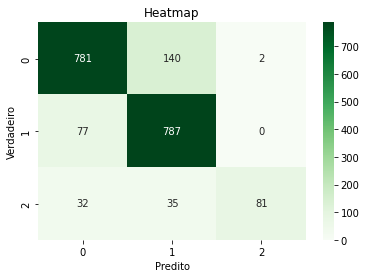

In [ ]:
cm = confusion_matrix(y_test, y_cat_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [ ]:
print(classification_report(y_test, y_cat_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       923
           1       0.82      0.91      0.86       864
           2       0.98      0.55      0.70       148

    accuracy                           0.85      1935
   macro avg       0.89      0.77      0.81      1935
weighted avg       0.86      0.85      0.85      1935



#Referências

[1] Mikolov, T., Le, Quoc (2014).  Distributed Representations of Sentences and Documents. arXiv:1405.4053v2. \\


[2] Amar Budhiraja (2018) https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da. Acesso em: 04/08/2021. \\

[3] Lau H. J., Baldwin T. An Empirical Evaluation of doc2vec with
Practical Insights into Document Embedding Generation. aclanthology: W16-1609. \\

[4] Abhinav Roy (2020) https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137. Acesso em: 04/04/2021. \\

[5] Araujo S. Filipe. Análise de Sentimento usando a Representação
Distribuída de Parágrafos para o Português. Universidade Federal do Pampa.
